In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

%matplotlib inline

In [150]:
def running_means(scores, opp_scores, mean_scores, threes, opp_threes):
    """
        Function takes in (scores, opp_scores) which are lists of a team's scores
        and the scores of its opponents. The function returns two lists which 
        are the running means of the team and the team's previous opponents.
    """
    
    # 'means' and opp_means are initialized with a NaN value because there is no
    # previous data to grab before the first game
    means = [np.nan]
    opp_means = [np.nan]
    avg_mean_scores = [np.nan]
    avg_threes = [np.nan]
    avg_opp_threes = [np.nan]
    
    # loops through each score and opponent score beginning with game 2
    for idx, (score, opp_score)  in enumerate(zip(scores[1:], opp_scores[1:])):
        
        # appends the running means
        means.append(scores[:idx+1].mean())
        opp_means.append(opp_scores[:idx+1].mean())
        avg_mean_scores.append(mean_scores[:idx+1].mean())
        
        # calculates percentage of points scored and given up by threes and then substracts the pre-calculated league average
        avg_threes.append(((threes[:idx+1]*3).mean() / means[idx+1]) - threes_pct)
        avg_opp_threes.append(((opp_threes[:idx+1]*3).mean() / opp_means[idx+1]) - threes_pct) 

    return means, opp_means, avg_mean_scores, avg_threes, avg_opp_threes

In [151]:
def get_logistics(year):
    # Grabs logistical data about the college basketball teams
    sources = teams_source[year].dropna()                  # website sources for each team
    teams = teams_source[year + '_Teams'].dropna()         # names of teams 
    team_nums = list(range(len(teams))) # idx numbers for each team
    team_dict = {teams[num]: num for num in team_nums}
    
    return year, sources, teams, team_dict

In [304]:
def webscrape_data(year, sources):
    dataframes = [] # list of dataframes

    # Loops through each team listed in the sources list of urls
    for ii, src in enumerate(sources):
        content = urllib.request.urlopen(src) # opens content of url
        read_content = content.read()   # reads content

        soup = BeautifulSoup(read_content,'html.parser')  # pass the content to BeautifulSoup to parse
        tags = soup.find_all('td') # grab only tags with 'td' which grabs the data table from the website

        data = []
        row = []
        # loops through extracted tag
        for idx, tr in enumerate(tags):
            row.append(tr.text) # appends text of the tag

            # Given that there are 39 columns of data in the table,
            # a check is perfromed on if the tag is the last tag
            # in the row
            if (idx + 1)%39 == 0: 

                # if the opponent team name ('idx 3'), does not an 'a' href,
                # then that team is not a Division 1 school and will not have 
                # data of its own in the dataframe. Because the program will use
                # data from the opponent, all data from non-Division 1 schools
                # is removed.
                if tags[idx - 36].find('a'):
                    data.append(row) # row of data is appended to data list if opponent is Division 1
                row = []

        # Removes cancelled game between Hampton and Morgan State
        # Score was 2-0 at the time of cancellation
        if (year == '2018') and ((ii == 112) or (ii == 191)):
            if ii == 112:
                data = data[:26] + data[27:]
            else:
                data = data[:24] + data[25:]

        # dataframe is created and key columns are renamed to better represent the data
        df = pd.DataFrame(data).rename(columns = {0: 'Date', 1: 'Loc', 2: 'Opp_name', 3: 'Win', 4: 'Score', 5: 'Opp_score', 9:'Threes', 26: 'Opp_Threes'})

        # datatypes of numerical columns are changed to floats 
        try:
            df = df.astype({key: float for key in df.keys() if key not in ['Date', 'Loc', 'Opp_name', 'Win', 22]})
        except ValueError: # handles value errors (by looking through the data it was determined there are a few instances where a cell was left blank)
            for col in df: # iterates through each column in dataframe
                float_vals = []
                for val in df[col]: # iterates through each value in column
                    try:
                        float_vals.append(float(val)) # converts to float if possible
                    except ValueError:   # used for values that cannot be converted to float
                        if col not in ['Date', 'Loc', 'Opp_name', 'Win', 22]:  # checks to make sure it wasn't supposed to be a String
                            float_vals.append(np.nan) # replace blank space with NaN
                        else:
                            float_vals.append(val) # leaves value as is

                df[col] = pd.Series(float_vals) # replaces column with new "float_values"

        # Convert 'Date' to datetime for evaluation later in runtime
        df['Date'] = pd.to_datetime(df['Date'])

        # The result column is added which represents how much the team lost or won by in that game
        # This will be a y-vector that the prediction model uses.
        df['result'] = df['Score'] - df['Opp_score']
        
        # The 'Win' column is 1 if the team won the game and 0 otherwise.
        # This will be another y-vector that the model predicts
        df['Win'] = np.where(df['result'] > 0, 1, 0)

        # Keep track of the Game Number
        df['Game_Number'] = list(range(1, len(df) + 1))

        # Calcultes the mean score of each game ( (team_score + opp_score) / 2 )
        df['Mean_Score'] = df[['Score', 'Opp_score']].mean(axis = 1)

        # Columns that represent the average scores of both the team and team's previous opponents
        # are added to the dataframe. This is done by calling the "running_means" function.
        # The data represents the averages going into the game
        df['Avg_Score'], df['Opp_Avg_Score'], df['Avg_Mean_Score'], df['Avg_Threes'], df['Opp_Avg_Threes'] = running_means(df['Score'], df['Opp_score'], df['Mean_Score'], df['Threes'], df['Opp_Threes'])

        # Calculates the average value of vicotry/loss
        df['Avg_Result'] = df['Avg_Score'] - df['Opp_Avg_Score']

        # Calculates the percent margin of victory/loss as percentage of mean scores
        df['Pct_Margin'] = df['Avg_Result'] / df['Avg_Mean_Score']

        # Create Dummy Variables for Home and Away
        location = pd.get_dummies(df['Loc'])
        if location.shape[1] == 3:
            location.columns = ['Home', 'Away', 'Neutral']
        else: # needed for teams that don't have any neutral-site games
            location.columns = ['Home', 'Away']   

        # concatenate original dataframe to new location dummy dataframe
        df = pd.concat((df, location), axis = 1)

        # create a column that contains the average season result in every row
        df['Avg_Result_Fin'] = [df['Score'].mean() - df['Opp_score'].mean()] * len(df)

        # Create a column that contains just the average result from non-conference games (first 10 games)
        df['Avg_Result_NC'] = list(df['Avg_Result'][:10]) + [df['Avg_Result'][9]] * (len(df) - 10)

        # saves dataframe
        df.to_csv('./Team_Dataframes/' + year + '/Team_Only/' + teams[ii] + '.csv', index = False)

        # add dataframe to list of dataframes
        dataframes.append(df)
    
    print('DONE WITH DATA INTAKE', year)
    return dataframes

In [301]:
def load_frames(teams=[], year='2016', multiple=False):
    
    if multiple:
        
        dataframes = pd.read_csv('./Final_Dataframes/Teams_Only.csv')
        
        dataframes['Date'] = pd.to_datetime(dataframes['Date'])
    
    else:
        
        dataframes = [pd.read_csv('./Team_Dataframes/' + year + '/Team_Only/' + teams[ii] + '.csv') for ii in range(len(teams))]

        for df in dataframes:

            # Convert 'Date' to datetime for evaluation later in runtime
            df['Date'] = pd.to_datetime(df['Date'])
    
    print('DONE LOADING FRAMES')
    
    return dataframes

In [302]:
# Grabs logistical data about the college basketball teams
def get_team_data(year='2016', multiple=False, scrape_data=False):
    """
       Returns team-specific data. Default arguments (year='2016', multiple=False, scrape_data=False).
       'year' specificies which year of data to collect.
       'multiple' will return only the 'year' of data when set to False, but will return all years when set to True
       'scrape_data' will load existing data if set to False, but will scrape data from the web if set to True
    """

    if multiple:

        years = ['2016', '2017', '2018', '2019']

        ## run if scraping new data
        if scrape_data:

            tot_frame = []

            for year in years:

                # grab logistical data such as web sources and team names
                year, sources, teams, team_dict = get_logistics(year)
                dataframes = webscrape_data(year, sources)
                tot_frame.append(pd.concat((dataframes)))

            tot_frame = pd.concat((tot_frame))
            tot_frame.to_csv('./Final_Dataframes/Teams_Only.csv', index=False)

        ## run if loading existing 
        else:

            tot_frame = load_frames(multiple=True)
            
        return tot_frame

    else:

        year, sources, teams, team_dict = get_logistics(year)

        ## run if scraping new data
        if scrape_data:

            dataframes = webscrape_data(year, sources)

        ## run if loading existing 
        else:

            dataframes = load_frames(teams=teams, year=year)

        return dataframes

In [305]:
teams_source = pd.read_excel('Team_Source.xlsx', header=None, names=['2016', '2017', '2018', '2019', '2016_Teams', '2017_Teams', '2018_Teams', '2019_Teams'])
threes_pct = 0.31352436210388857 # pre-calculated number for percentage of points scored from 3-pointers by all teams in the league
    
teams_df = get_team_data(multiple=True, scrape_data=True)

DONE WITH DATA INTAKE 2016
DONE WITH DATA INTAKE 2017
DONE WITH DATA INTAKE 2018
DONE WITH DATA INTAKE 2019


In [270]:
def combine_data(dataframes):
    """
    Takes in a list of dataframes.
    Function looks at team's opponents' dataframes and concatenates the team's dataframe
    with data from the opponents.
    Returns a list of concatenated dataframes for each team
    """
    
    # Initialize a list of dataframes that will combine a team's dataframe with data from its opponents
    combined_df = []

    # loop through each dataframe (team)
    for ii, df in enumerate(dataframes):

        # initialize a list that will represent the strength of schedule of the team entering the game
        # initialized with NaN because there would be no previous opponents entering the first game
        sos = [np.nan]
        sos_all = [np.nan] # uses final average result from each previous opponent
        sos_nc = [np.nan] # team's non-conference SOS

        # initialize a list that will represent the strength of schedule of the team's previous opponents
        # entering the game
        # initialized with NaN because there would be no previous opponents entering the first game
        prev_sos = [np.nan]
        prev_sos_all = [np.nan] # uses final average result from each previous opponent
        prev_sos_nc = [np.nan] # team's non-conference SOS

        # Initializes a list that will represent the strength of schedule of the opponent entering the game
        # This list is not initialized with NaN because the opponent may have already played a game before
        # the team's first game
        opp_sos =[]
        opp_sos_nc = []

        # list that will contain data of opponent
        opp_data = []

        # names of all opponents
        opp_names = df['Opp_name']

        # loops through every game, specifically by enumerating the opponent name column
        for idx, name in enumerate(opp_names):

            # will loop through each team's opponent prior to current game
            # first checks if idx is greater than 0 because there are no games
            # before the first game
            if idx > 0:
                
                date_check = df['Date'][idx]
                
                # list of all previous opponents
                prev_opps = opp_names[:idx]

                # list that will store average win/loss results for each previous opponent
                avg_results = []
                sos_all_results = [] # stores the final average score for each previous opponent
                sos_nc_games = []

                # lists that will store average win/loss results for each previous opponent's previous opponents
                prev_prev_avg_results = []
                prev_sos_all_results = []
                prev_sos_nc_games = []

                # loop through each previous opponent
                for jj, prev_name in enumerate(prev_opps):

                    # previous opponent dataframe
                    prev_df = dataframes[team_dict[prev_name]]
                    
                    len_prev = len(prev_df)

                    # loops through each game for previous opponent
                    for idx3, date2 in enumerate(prev_df['Date']):
                        if date2 >= date_check:
#                             prev_avg_result = prev_df['result'][:idx3].mean()
                            prev_avg_result = prev_df['Avg_Result'][idx3]
                            prev_opp_prev = prev_df['Opp_name'][:idx3]
                            break
                        elif idx3 == (len_prev - 1):
                            #prev_avg_result = prev_df['result'].mean()
                            prev_avg_result = prev_df['Avg_Result_Fin'][0]
                            prev_opp_prev = prev_df['Opp_name']
                            break     

                    ## Only grabs index <= 10 as that is about how many pre-conference
                    ## games each team plays
                    if jj <= 10:
                        sos_nc_games.append(prev_avg_result)

                    ## append strength of schedule data
                    avg_results.append(prev_avg_result)
                    sos_all_results.append(prev_df['Avg_Result_Fin'][0])

                    # loops through the previous opponents of the previous opponent
                    # to find the SOS of previous opponents
                    for prev_opp in prev_opp_prev:

                        prev2_df = dataframes[team_dict[prev_opp]]
                        
                        len_prev2 = len(prev2_df)

                        for kk, date_kk in enumerate(prev2_df['Date']):
                            if date_kk >= date_check:
                                #prev_prev_avg_result = prev2_df['result'][:kk].mean()
                                prev_prev_avg_result = prev2_df['Avg_Result'][kk]
                                break
                            elif kk == (len_prev2 - 1):
                                #prev_prev_avg_result = prev2_df['result'].mean()
                                prev_prev_avg_result = prev2_df['Avg_Result_Fin'][0]
                                break   

                        ## Only grabs index <= 10 as that is about how many pre-conference
                        ## games each team plays
                        if kk <= 10:
                            prev_sos_nc_games.append(prev_prev_avg_result)

                        ## append strength of schedule data
                        prev_prev_avg_results.append(prev_prev_avg_result)
                        prev_sos_all_results.append(prev2_df['Avg_Result_Fin'][0])

                # take means of SOS data to provide singular value for each game
                prev_sos.append(np.array(prev_prev_avg_results).mean())
                prev_sos_all.append(np.array(prev_sos_all_results).mean())
                #prev_sos_nc.append(np.array(prev_sos_nc_games).mean())

                # take means of SOS data to provide singular value for each game
                sos.append(np.array(avg_results).mean())
                sos_all.append(np.array(sos_all_results).mean())
                sos_nc.append(np.array(sos_nc_games).mean())

            opp_df = dataframes[team_dict[name]] # opponent's dataframe

            # loops through each game in opponent's dataframe to find the matching date which
            # would represent the same game
            for idx2, date in enumerate(opp_df['Date']):
                if date == date_check:
                    opp_data.append(opp_df.loc[idx2]) # appends data from opponent's game
                    break

            # will loop through each previous opponent of that game's opponent prior to current game
            # first checks if idx2 is greater than 0 because there are no games
            # before the first game
            if idx2 > 0:

                # list of opponent's previous opponents before current game
                opp_prev_opps = opp_df['Opp_name'][:idx2]

                # list that will store average win/loss results for each opponent of current game's opponent
                opp_avg_results = []
                opp_sos_nc_games = []

                # loop through each previous opponent of opponent
                for kk, opp_prev_name in enumerate(opp_prev_opps):

                    # previous opponent's opponent dataframe
                    opp_prev_df = dataframes[team_dict[opp_prev_name]]
                    
                    len_opp_prev = len(opp_prev_df)
                    
                    # checks the dates of games of the opponent's previous opponent 
                    # will look at games prior to current game date
                    for idx4, date3 in enumerate(opp_prev_df['Date']):
                        if date3 >= date_check:
                            #opp_prev_avg_result = opp_prev_df['result'][:idx4].mean()
                            opp_prev_avg_result = opp_prev_df['Avg_Result'][idx4]
                            break
                        elif idx4 == (len_opp_prev - 1):
                            #opp_prev_avg_result = opp_prev_df['result'].mean()
                            opp_prev_avg_result = opp_prev_df['Avg_Result_Fin'][0]
                            break

                    # appends the average result of opponent's opponent's previous games
                    opp_avg_results.append(opp_prev_avg_result)

                    if kk <= 10:
                        opp_sos_nc_games.append(opp_prev_avg_result)

                # appends the average results of all opponent's previous opponents previous games
                opp_sos.append(np.array(opp_avg_results).mean())
                opp_sos_nc.append(np.array(opp_sos_nc_games).mean())
            else:
                opp_sos.append(np.nan)
                opp_sos_nc.append(np.nan)

        # Converts the opponents' data to a dataframe and then renames the columns to avoid duplication of column names and 
        # provide clarity as to what the different columns represent
        opp_data_df = pd.DataFrame(opp_data, index = list(range(len(opp_data))))
        opp_data_df = opp_data_df.rename(columns = {'result': 'result2', 'Mean_Score': 'Mean_Score2', 'Opp_Avg_Score': 'Opp_Avg_Score2', 'Avg_Score': 'Avg_Score2',
                                                    'Avg_Mean_Score': 'Avg_Mean_Score2', 'Avg_Result': 'Avg_Result2', 'Pct_Margin': 'Pct_Margin2', 'Home': 'Home2',
                                                    'Away': 'Away2', 'Neutral': 'Neutral2', 'Date': 'Date2', 'Loc': 'Loc2', 'Opp_Name': 'Opp_Name2', 'Win': 'Win2',
                                                    'Opp_Score': 'Opp_Score2', 'Score': 'Score2', 'Threes': 'Threes2', 'Opp_Threes': 'Opp_Threes2',
                                                    'Avg_Threes': 'Avg_Threes2', 'Opp_Avg_Threes': 'Opp_Avg_Threes2', 'Game_Number': 'Game_Number2',
                                                    'Avg_Result_Fin': 'Avg_Result_Fin2', 'Avg_Result_NC': 'Avg_Result_NC2'})

        # Converts the strength of schedule lists to dataframes that can be appended
        sos_df = pd.DataFrame()
        sos_df['SOS'] = sos        # Strength of schedule using all previous opponents
        sos_df['SOS_NC'] = sos_nc  # Strength of schedule using only non-conference opponentes (first 10 opponents)
        sos_df['Opp_SOS'] = opp_sos # Opponent's SOS using all previous opponents
        sos_df['Opp_SOS_NC'] = opp_sos_nc
        sos_df['Prev_SOS'] = prev_sos
        sos_df['SOS_Fin'] = [sos_df['SOS'][len(sos_df) - 1]] * len(sos_df) # column that contains the final SOS
        sos_df['SOS_All'] = sos_all
        sos_df['SOS_All_Fin'] = [sos_df['SOS_All'][len(sos_df) - 1]] * len(sos_df) 

        df['Scoring_Pace_Diff'] = (df['Avg_Mean_Score'] - opp_data_df['Avg_Mean_Score2'])/2

        # Looks at the relative percentage of points scored and given up by 3-pointers and multiplies that
        # by the factor of the oppponent
        team_score = df['Avg_Threes'] * opp_data_df['Opp_Avg_Threes2']
        opp_score = df['Opp_Avg_Threes'] * opp_data_df['Avg_Threes2']
        df['Matchup_Comp'] = team_score / (abs(team_score) ** 0.5) 
        df['Opp_Matchup_Comp'] = opp_score / (abs(opp_score) ** 0.5) 

        # combines original dataframe with data from game opponents, SOS of team, and SOS of opponents
        combined_df.append(pd.concat([df, opp_data_df, sos_df], axis = 1))

        # saves dataframe
        #combined_df[ii].to_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[ii] + '.csv', index = False)

        if ii%20 == 0:
            print(ii)
    
    # list of concatenated dataframes
    return combined_df

,Date,Loc,Opp_name,Win,Score,Opp_score,6,7,8,Threes,...,Avg_Result_Fin2,Avg_Result_NC2,SOS,SOS_NC,Opp_SOS,Opp_SOS_NC,Prev_SOS,SOS_Fin,SOS_All,SOS_All_Fin
0,2017-11-13,@,Arkansas State,L,69.0,83.0,25.0,49.0,0.510,3.0,...,-6.633333,-14.000000,NaN,NaN,14.000000,14.000000,NaN,-2.333862,NaN,-2.616724
1,2017-11-20,NaN,Lipscomb,L,67.0,75.0,25.0,56.0,0.446,6.0,...,1.700000,-12.666667,-5.666667,-5.666667,11.333333,11.333333,3.833333,-2.333862,-6.633333,-2.616724
2,2017-11-24,@,Campbell,W (1 OT),85.0,80.0,33.0,65.0,0.508,8.0,...,1.000000,-7.500000,-5.750000,-5.750000,1.083333,1.083333,1.244444,-2.333862,-2.466667,-2.616724
3,2017-11-25,N,USC Upstate,L,78.0,88.0,27.0,58.0,0.466,8.0,...,-13.107143,-10.750000,-6.444444,-6.444444,3.516667,3.516667,0.298168,-2.333862,-1.311111,-2.616724
4,2017-11-26,N,Bowling Green State,W,88.0,83.0,34.0,64.0,0.531,6.0,...,-3.500000,3.600000,-6.441667,-6.441667,-0.606667,-0.606667,0.500501,-2.333862,-4.260119,-2.616724


In [128]:
year, _, teams, team_dict = get_logistics('2016')

combined_df = [pd.read_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))]

for idx, df in enumerate(combined_df):
    
    df['Avg_Result_NC'] = dataframes[idx]['Avg_Result_NC']

# for idx, df in enumerate(combined_df):
    
#     # Convert 'Date' to datetime for evaluation later in runtime
#     df['Date'] = pd.to_datetime(df['Date'])
    
#     nc2 = []

# #     opp_prev_opp_sos = []
    
#     for ii, name in enumerate(df['Opp_name']):
       
#         opp_df = dataframes[team_dict[name]] # opponent's dataframe

# #         for jj, opp_prev_opp in enumerate(opp_df['Opp_name']):
            
# #             opp_prev_opp_prev_results = []
            
# #             if opp_df['Date'][jj] == df['Date'][ii]:
                
# #                 if ii > 0:
                
# #                     opp_prev_names = opp_df['Opp_name'][:jj] # list of opponent's previous opponents before current game
                   
# #                     # loops through the previous opponents of the opponent
# #                     for opp_prev_name in opp_prev_names:

# #                         prev2_df = dataframes[team_dict[opp_prev_name]] # dataframe of opponent's previous opponent

# #                         for kk, date_kk in enumerate(prev2_df['Date']):
# #                             if date_kk >= df['Date'][ii]:
# #                                 opp_prev_opp_prev = prev2_df['Opp_name'][:kk] # opponent's opponent's previous opponents    
# #                                 break
# #                             elif kk == (len(prev2_df['Date']) - 1):
# #                                 opp_prev_opp_prev = prev2_df['Opp_name']
# #                                 break
                        
# #                         opp_prev_opp_prev_result = []
                        
# #                         for name in opp_prev_opp_prev:

# #                             opp_prev_opp_prev_df = dataframes[team_dict[name]]

# #                             for ll, date_ll in enumerate(opp_prev_opp_prev_df['Date']):

# #                                 if date_ll >= df['Date'][ii]:
# #                                     opp_prev_opp_prev_result.append(opp_prev_opp_prev_df['Avg_Result'][ll])
                                    
# #                                     break
# #                                 elif ll == (len(opp_prev_opp_prev_df) - 1):
# #                                     opp_prev_opp_prev_result.append(opp_prev_opp_prev_df['Avg_Result_Fin'][0])
                                
# #                         opp_prev_opp_prev_results.append(np.mean(opp_prev_opp_prev_result))
                        
# #                     opp_prev_opp_sos.append(np.mean(opp_prev_opp_prev_results))

# #                 else:
# #                     opp_prev_opp_sos.append(np.nan)
                
# #                 break
                   
# #     df['Opp_Prev_SOS'] = opp_prev_opp_sos                 




        
#         for jj, date in enumerate(opp_df['Date']):

#             if date == df['Date'][ii]:
#                 nc2.append(opp_df['Avg_Result_NC'][jj])
#                 break
    
#     df['Avg_Result_NC2'] = nc2

    
    
    df.to_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[idx] + '.csv', index = False)
    #combined_df[ii].to_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[ii] + '.csv', index = False)

combined_df[0].head()

351


,Date,Loc,Opp_name,Win,Score,Opp_score,6,7,8,Threes,...,Prev_SOS,SOS_Fin,SOS_All,SOS_All_Fin,Scoring_Pace_Diff,Matchup_Comp,Opp_Matchup_Comp,Opp_Prev_SOS,Avg_Result_NC2,Avg_Result_NC
0,2015-11-22,@,Portland,L,57.0,87.0,15.0,52.0,0.288,5.0,...,NaN,-3.152793,NaN,-3.183298,NaN,NaN,NaN,NaN,-17.500000,NaN
1,2015-11-24,@,Colorado State,L (2 OT),100.0,108.0,33.0,70.0,0.471,14.0,...,-6.833333,-3.152793,-2.774194,-3.183298,-6.000000,-0.041127,0.044415,2.548148,6.666667,-30.000000
2,2015-11-27,N,Florida A&M,W,72.0,62.0,23.0,51.0,0.451,7.0,...,-8.056250,-3.152793,-0.996472,-3.183298,10.083333,-0.043113,0.012525,-19.977778,-31.000000,-19.000000
3,2015-11-28,N,Oakland,L,57.0,85.0,20.0,64.0,0.313,3.0,...,2.110714,-3.152793,-4.355673,-3.183298,-1.750000,0.028060,-0.010150,4.694722,7.000000,-9.333333
4,2015-12-03,NaN,New Hampshire,L,75.0,86.0,24.0,50.0,0.480,8.0,...,-1.214905,-3.152793,-1.288183,-3.183298,3.350000,-0.028670,-0.007722,-0.433605,-2.800000,-14.000000


In [274]:
# list of years that data was scraped (potential for more)
years = ['2016', '2017', '2018', '2019']

# Initialize a dataframe
cbb_df = pd.DataFrame()

# go through each year of saved data
for year in years:
    
    # List of team names for that year
    teams = teams_source[year + '_Teams'].dropna() 
    
    # concatenated dataframe from all team dataframes
    new_dfs = pd.concat([pd.read_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))])
    
    # concatenate each year of data
    cbb_df = pd.concat((cbb_df, new_dfs))
    
cbb_df.to_csv('./Final_Dataframes/Teams_Combined.csv', index=False)
    
print(cbb_df.shape)

(44386, 123)


In [121]:
######### Regression on individual year

lr = LinearRegression()

features = ['Avg_Result', 'Avg_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Avg_Result_NC', 'Opp_Prev_SOS', 'Avg_Result_NC2']
#features = ['SOS_NC']

data = combined_df[0].dropna(subset=features)
X = data[features]
y = data['result']

for df in combined_df[1:]:
    
    frame = df.dropna(subset=features)
    #X = pd.concat((X, df[['Avg_Score', 'Opp_Avg_Score', 'Opponent_Avg_Score', 'Opp_Opp_Avg_Score', 'Home', 'Away']]))#, 'SOS', 'Opp_SOS']]))
    #X = pd.concat((X, df[['Avg_Result', 'Avg_Result2', 'Scoring_Pace_Diff', 'Home', 'Away', 'SOS', 'Opp_SOS']]))
    #X = pd.concat((X, df[df['Game_Number'] >= 10][['Avg_Result', 'Avg_Result2', 'Scoring_Pace_Diff', 'Home', 'Away', 'SOS', 'Opp_SOS']]))
    X = pd.concat((X, frame[features]))
    
    #y = pd.concat((y, df[df['Game_Number'] >= 10]['result']))
    y = pd.concat((y, frame['result']))


##### All years
data = cbb_df.dropna(subset=features)
print(data.shape)
X = data[features]
y = data['result']
    
    
MSEs = []
SE = []
stds = []
scores = []
    
for ii in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lr.fit_intercept = False
    lr.fit(X_train, y_train)
    #print('Coefficients:',lr.coef_)

    y_pred = lr.predict(X_test)

    resid = y_pred - y_test
    
    SE.append(np.std(resid, ddof=len(features)) / np.sqrt(np.size(resid)))
    stds.append(np.std(resid, ddof=len(features)))
    MSEs.append(mean_squared_error(y_test, y_pred))
    scores.append(lr.score(X_test, y_test))

print('Standard Error:', np.mean(SE))
print('Standard Deviation (ddof)', np.mean(stds))
#print('Standard Deviation', np.std(resid))
print('MSE:', np.mean(MSEs))
print('Scores:', np.mean(scores))

model = sm.OLS(y_train, X_train, missing = 'drop') # sm.add_constant(X)
results = model.fit()

print(results.summary())

cv_scores = cross_val_score(LinearRegression(), X, y, cv=KFold(10, shuffle=True))

print(cv_scores.mean())

(42262, 120)
Standard Error: 0.11235638404020698
Standard Deviation (ddof) 11.54923071150122
MSE: 133.29538363108074
Scores: 0.40775640743059594
                                 OLS Regression Results                                
Dep. Variable:                 result   R-squared (uncentered):                   0.405
Model:                            OLS   Adj. R-squared (uncentered):              0.405
Method:                 Least Squares   F-statistic:                              2156.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):                        0.00
Time:                        15:39:57   Log-Likelihood:                     -1.2252e+05
No. Observations:               31696   AIC:                                  2.451e+05
Df Residuals:                   31686   BIC:                                  2.452e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                          

In [132]:
def get_linear_stats(X, y, n_runs=10, n_folds=10):
    """
        Takes in X and y data and returns Linear Model statistics.
        Returns Standard Error, Standard Deviation, Mean Squared Error,
        Cross-Validation Score, and statsmodels OLS results.
        
        n_runs is the number of training runs to perform. An increase in n_runs
        provides more stable results.
        
        n_folds is the number of folds to create in the cross-validation test
    """
    
    # Initialized Linear Regression model
    lr = LinearRegression()
    
    # drops null values from data input
    X = X.dropna()
    y = y.dropna()
    
    # number for features in model
    num_features = X.shape[1]
    
    # initializes statistics that will be averaged
    MSEs = []
    SE = []
    stds = []
    scores = []
    
    # Number of training runs
    # Increase in runs stabilizes results
    for ii in range(n_runs):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        lr.fit_intercept = False
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)
        
        # Difference between predicted results and test data
        resid = y_pred - y_test
        
        # Append statistics
        SE.append(np.std(resid, ddof=num_features) / np.sqrt(np.size(resid)))
        stds.append(np.std(resid, ddof=num_features))
        MSEs.append(mean_squared_error(y_test, y_pred))
        scores.append(lr.score(X_test, y_test))
        
    cv_scores = cross_val_score(LinearRegression(), X, y, cv=KFold(n_folds, shuffle=True))
    
    # Develop OLS model
    model = sm.OLS(y_train, X_train, missing = 'drop') # sm.add_constant(X)
    results = model.fit()
    
    return np.mean(SE), np.mean(stds), np.mean(MSEs), cv_scores.mean(), results

0.1125549518725204 11.569641707519478 133.76612037766463 0.4071701215946173
                                 OLS Regression Results                                
Dep. Variable:                 result   R-squared (uncentered):                   0.411
Model:                            OLS   Adj. R-squared (uncentered):              0.411
Method:                 Least Squares   F-statistic:                              2210.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:04:45   Log-Likelihood:                     -1.2249e+05
No. Observations:               31696   AIC:                                  2.450e+05
Df Residuals:                   31686   BIC:                                  2.451e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err        

In [280]:
features = ['Avg_Result', 'Avg_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Avg_Result_NC', 'Opp_Prev_SOS', 'Avg_Result_NC2']

data = cbb_df.dropna(subset=features)

X = data[features]
y = data['result']

SE, STD, MSE, CV, model = get_linear_stats(X, y)

print(SE, STD, MSE, CV)
print(model.summary())

0.129315121447818 11.57352276045898 133.79953235929253 0.4063614424897727
                                 OLS Regression Results                                
Dep. Variable:                 result   R-squared (uncentered):                   0.406
Model:                            OLS   Adj. R-squared (uncentered):              0.406
Method:                 Least Squares   F-statistic:                              1642.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):                        0.00
Time:                        10:43:15   Log-Likelihood:                         -92750.
No. Observations:               24028   AIC:                                  1.855e+05
Df Residuals:                   24018   BIC:                                  1.856e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          

In [ ]:
plt.scatter(list(range(len(resid))), resid, alpha = 0.7);
plt.title('Residual Plot')
plt.xlabel('Square Ft')
plt.ylabel('Price Difference Between predicted and Actual')
plt.axhline(0, c = 'g');

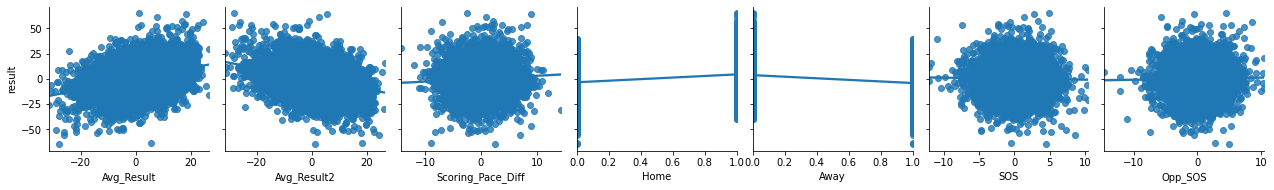

In [637]:
#sns.residplot(X, y);
sns.pairplot(pd.concat((X, y), axis = 1), x_vars=['Avg_Result', 'Avg_Result2', 'Scoring_Pace_Diff', 'Home', 'Away', 'SOS', 'Opp_SOS'], y_vars='result', kind='reg');

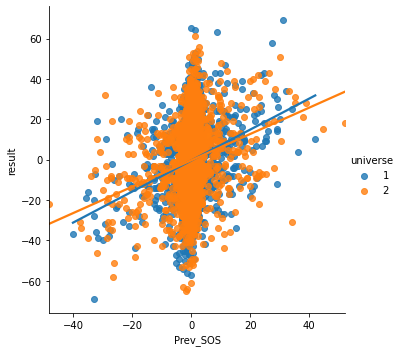

In [45]:
X['universe'] = np.random.randint(1, 3, len(X))

sns.lmplot(x = 'Prev_SOS', y='result', hue='universe', data=pd.concat((X, y), axis = 1), ci=False);

In [127]:
## Square the x-variables to represent
X2s = pd.concat((X, X[['SOS_NC', 'Opp_SOS_NC']] ** 3), axis = 1)

## Split the data up into train and test values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y)

## Create Linear Regression model
lr.fit_intercept = False
lr = LinearRegression()
lr.fit(X2_train, y2_train)

## Calculate scores of new model on training data (MSE and R^2)
y2_pred_train = lr.predict(X2_train)
print('Train MSE:', mean_squared_error(y2_train, y2_pred_train))
print('Train Score:', lr.score(X2_train, y2_train))

## Calculate scores of new model on test data (MSE and R^2)
y2_pred_test = lr.predict(X2_test)
print('Test MSE:', mean_squared_error(y2_test, y2_pred_test))
print('Test Score:', lr.score(X2_test, y2_test))

MSEs = []
SE = []
stds = []
scores = []
    
for ii in range(100):
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y)

    lr.fit_intercept = False
    lr.fit(X2_train, y2_train)
    #print('Coefficients:',lr.coef_)

    y2_pred = lr.predict(X2_test)

    resid = y2_pred - y2_test
    
    SE.append(np.std(resid, ddof=len(features) + 2) / np.sqrt(np.size(resid)))
    stds.append(np.std(resid, ddof=len(features) + 2))
    MSEs.append(mean_squared_error(y2_test, y2_pred))
    scores.append(lr.score(X2_test, y2_test))

print('Standard Error:', np.mean(SE))
print('Standard Deviation (ddof)', np.mean(stds))
#print('Standard Deviation', np.std(resid))
print('MSE:', np.mean(MSEs))
print('Scores:', np.mean(scores))

Train MSE: 137.03144618816856
Train Score: 0.4111866244760036
Test MSE: 130.55324734371004
Test Score: 0.3922299330320854
Standard Error: 0.23534309139952161
Standard Deviation (ddof) 11.665518108293398
MSE: 135.6815210132989
Scores: 0.4027128331961932


Standard Error: 0.23724525028148086
Standard Deviation 11.759804576404234
Standard Deviation 11.743040769483436


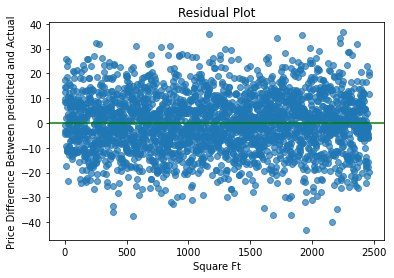

In [83]:
y_pred = lr.predict(X_test)

resid = y_pred - y_test

plt.scatter(list(range(len(resid))), resid, alpha = 0.7);
plt.title('Residual Plot')
plt.xlabel('Square Ft')
plt.ylabel('Price Difference Between predicted and Actual')
plt.axhline(0, c = 'g');

print('Standard Error:', np.std(resid, ddof=7) / np.sqrt(np.size(resid)))
print('Standard Deviation', np.std(resid, ddof=7))
print('Standard Deviation', np.std(resid))

In [163]:
a = np.nan
b = []
b.append(a)
b.append(1)
b.append(2)
np.mean()

[nan, 1, 2]

In [602]:
tot_points = 0
tot_threes = 0
avg_tester = 0
opp_avg_tester = 0
for df in dataframes:
#     tot_points += df['Score'].sum()
#     tot_threes += df['Threes'].sum() * 3
    avg_tester += df['Avg_Threes'].sum()
    opp_avg_tester += df['Opp_Avg_Threes'].sum()

# print('Points', tot_points)
# print('Threes', tot_threes)
print('Avg_Threes', avg_tester)
print('Opp_Avg_Threes', opp_avg_tester)

Avg_Threes -19.33489881901047
Opp_Avg_Threes -18.702696497566826


In [13]:
a = [1, 2, 3]
b = [[4, 5, 6]]

c = pd.DataFrame([a, b])
c = pd.DataFrame()
c['a'] = a
c

,a
0,1
1,2
2,3


In [295]:
len(cbb_df)

44386

In [94]:
b = pd.concat((a))

In [95]:
b

,0
0,1
0,2
0,3
